In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import emcee
sb.set_style('white')
%config InlineBackend.figure_format = 'retina'

In [2]:
from models_EF import *

In [3]:
#background = np.loadtxt('data/O_cen_data_Bck_no_events.txt',usecols=(1),unpack=True)[:7]
#background = np.loadtxt('back_events.txt',usecols=(1),unpack=True)

In [4]:
print len(background)

7


In [5]:
#Ener,no_events,el,er = np.loadtxt('number_of_events.txt',unpack=True)
Ener,no_events,e_min,e_max = np.loadtxt('data/OC_no_events_9_bins.txt',usecols=(0,1,2,3),unpack=True)

In [6]:
print e_min, e_max

[  200.           369.37524414   682.19030762  1259.92102051
  2326.91821289  4297.52929688  7937.00537109 14658.66601562
 27072.74023438] [  369.37524414   682.19030762  1259.92102051  2326.91821289
  4297.52929688  7937.00537109 14658.66601562 27072.74023438
 50000.        ]


In [7]:
print no_events

[152. 135. 130. 132.  95.  23.   8.   0.   0.]


In [8]:
#Ener,no_events,el,er = np.loadtxt('data/O_cen_data_no_events.txt',usecols=(0,1,2,3),unpack=True)

In [9]:
#Ener,no_events,el,er = Ener[:7],no_events[:7],el[:7],er[:7]

In [10]:
mask = no_events != 0.0

In [11]:
Ener = Ener[mask]
no_events = no_events[mask]
e_min = e_min[mask]
e_max = e_max[mask]

In [12]:
print len(no_events), len(background)

7 7


In [13]:
print no_events

[152. 135. 130. 132.  95.  23.   8.]


In [14]:
#no_events = no_events - background

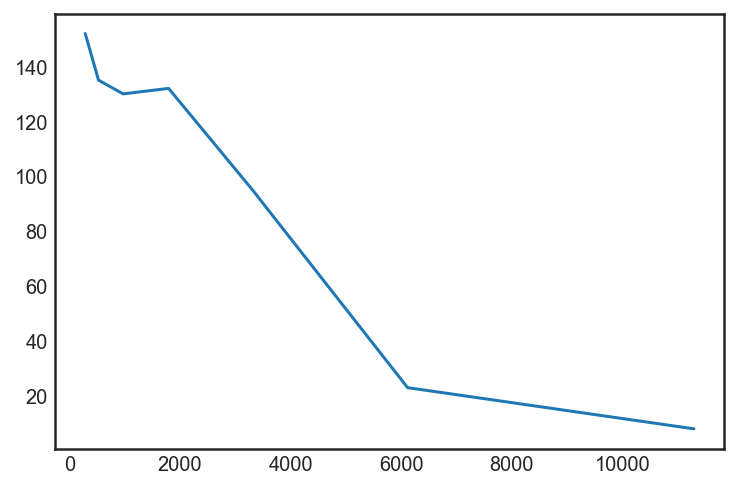

In [15]:
plt.plot(Ener,no_events);

In [16]:
print Ener[0]

284.6876220703125


e_min = Ener - el
e_max = Ener + er

In [17]:
print e_min
print e_max

[ 200.          369.37524414  682.19030762 1259.92102051 2326.91821289
 4297.52929688 7937.00537109]
[  369.37524414   682.19030762  1259.92102051  2326.91821289
  4297.52929688  7937.00537109 14658.66601562]


In [18]:
from scipy import optimize as op

In [19]:
fun2 = lambda *args: -event_lnhood(*args)

In [20]:
mid_2 = [1.,3.,-6.,-6.,1.5]
bnds_2 = ((0.,3.), (2.,4.), (-18.,0.),(-15.,0.),(0.,5.))

In [21]:
print event_lnhood(mid_2,no_events,e_min,e_max,'p+b',None,None,None)

-40684.63969589625


In [22]:
result2 = op.minimize(fun2, mid_2, args=(no_events,e_min,e_max,'p+b',None,None,None),method = 'TNC',bounds=bnds_2)

In [23]:
print result2.x

[ 1.04994434  3.28048176 -8.30110257 -6.02824437  1.42630547]


In [24]:
p_list_2 = [0.,3., 2.,4.,-18.,0.,-15.,0.,0.,5.]

In [25]:
nwalkers = 200
ndim = (len(p_list_2)/2) 

In [26]:
print ndim

5


In [27]:
z = np.zeros((ndim,nwalkers))

In [28]:
h = 1e-2

pos_i=[]


for i in range(ndim):
    z[i,:] = result2.x[i] + h*np.random.randn(nwalkers)

for i in range(nwalkers):
    pos_i.append(np.array([z[0,i],z[1,i],z[2,i],z[3,i],z[4,i]]))

In [29]:
b_steps, steps = 500, 2000

In [30]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,event_lnpost, 
                                args=(no_events,e_min,e_max,'p+b',p_list_2,None,None,None),
                                threads = 2)

In [31]:
pos,prob,state=sampler.run_mcmc(pos_i, b_steps)

In [32]:
print sampler.acceptance_fraction.mean()

0.38974000000000003


In [33]:
sampler.reset()

In [34]:
_,_,_=sampler.run_mcmc(pos, steps, rstate0=state)

In [35]:
print sampler.acceptance_fraction.mean()

0.37099499999999996


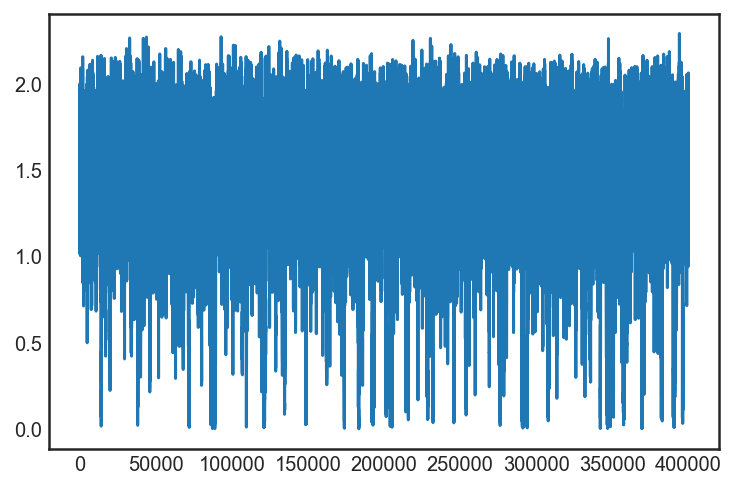

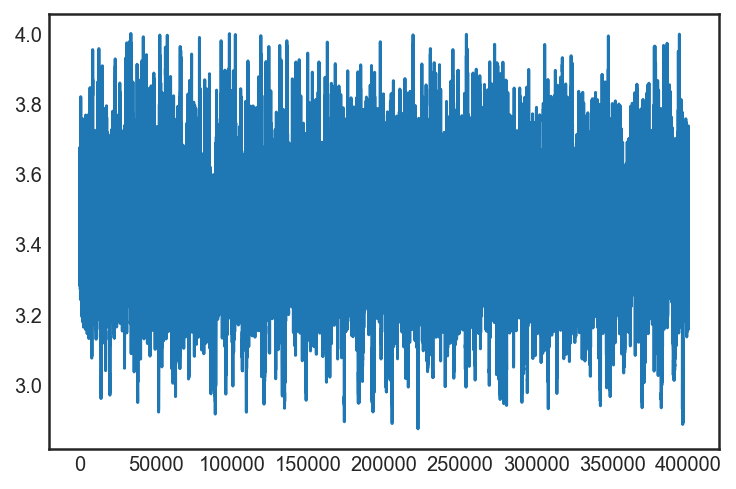

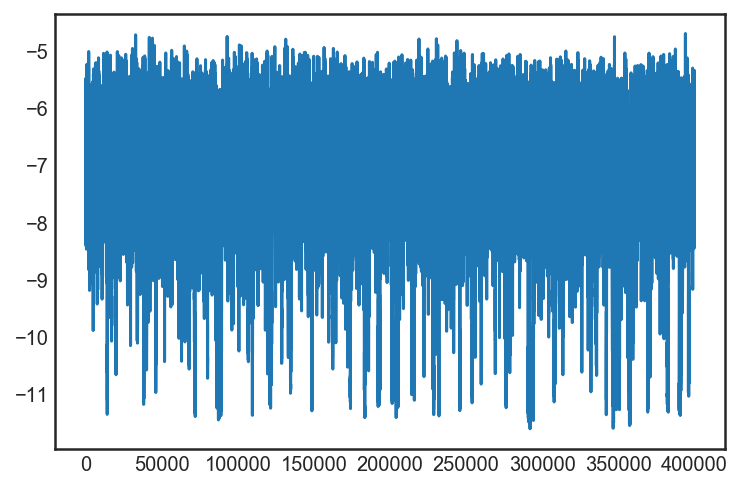

In [36]:
plt.figure()
plt.plot(sampler.flatchain[:,0]);
plt.figure()
plt.plot(sampler.flatchain[:,1]);
plt.figure()
plt.plot(sampler.flatchain[:,2]);

In [37]:
import corner as corner 

In [38]:
labels = [r'$\Gamma$',r'$log10(E_{cut})$','log10(N0)',r'$log10(N_N)$',r'$\alpha$']

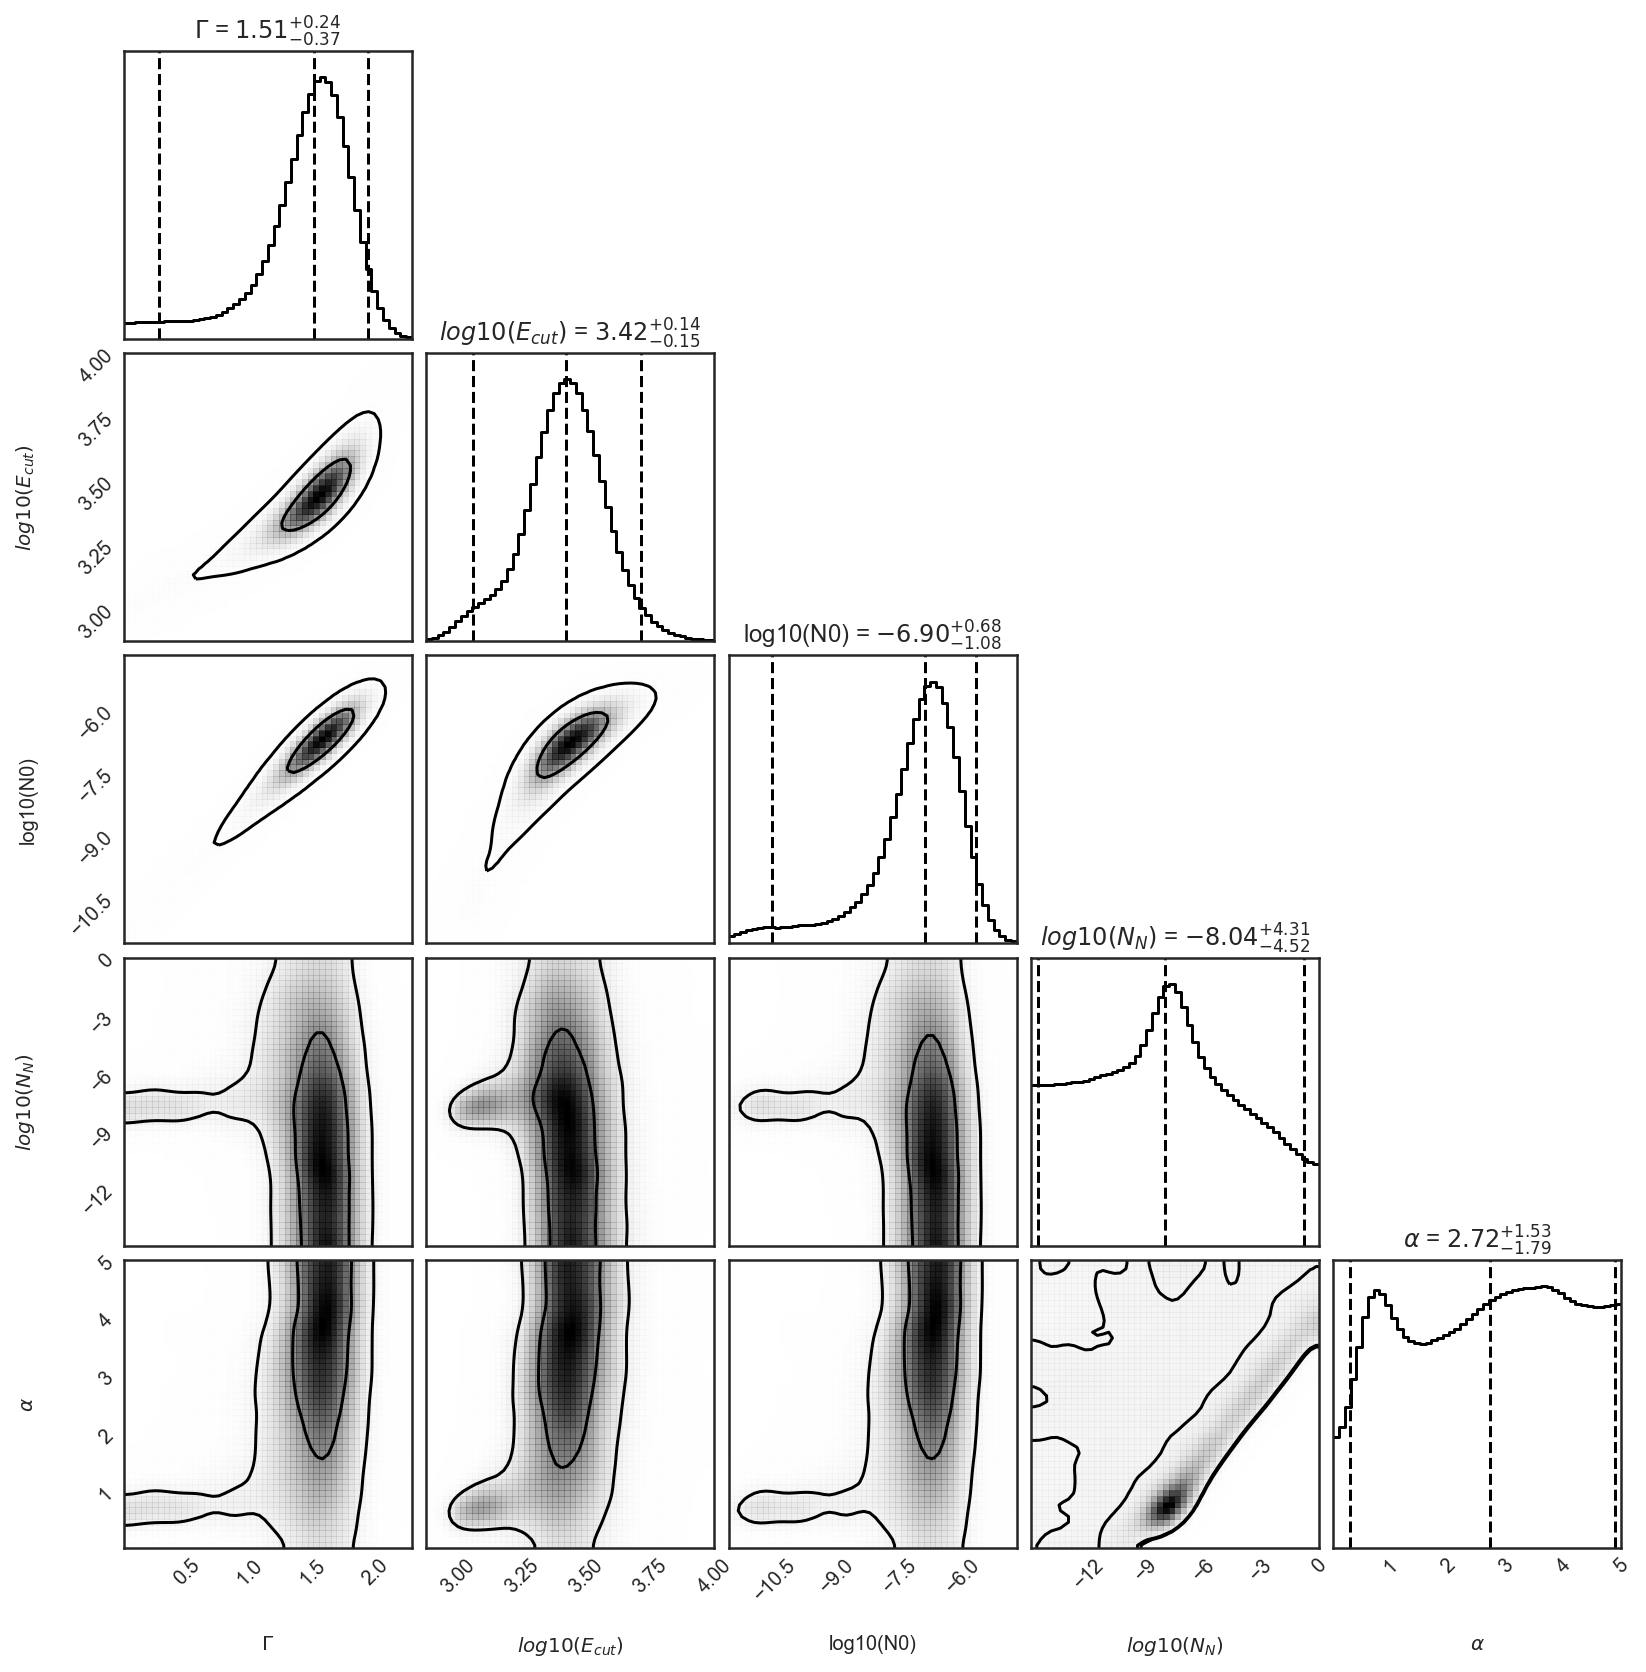

In [39]:
fig = corner.corner(sampler.flatchain,bins=50,labels=labels,plot_datapoints=False,smooth=2., 
                    smooth1d=2,levels=(1.-np.exp(-0.5),1.-np.exp(-2.)),quantiles=[.025,0.5,0.975],show_titles=True);

fig.savefig('data/data9_bin_ecut_flat.pdf')

In [40]:
events = no_events_model_pulsar([0.7,np.log10(2500.),1.4],e_min,e_max)

In [41]:
print events

[4.45384854e+11 1.67144628e+12 4.62003598e+12 8.61377418e+12
 9.28974090e+12 5.08864196e+12 1.13220574e+12]


In [42]:
10.**3.37

2344.228815319923

np.savetxt('chains/chains_ecut_0709_newsource_flar.dat',sampler.flatchain)

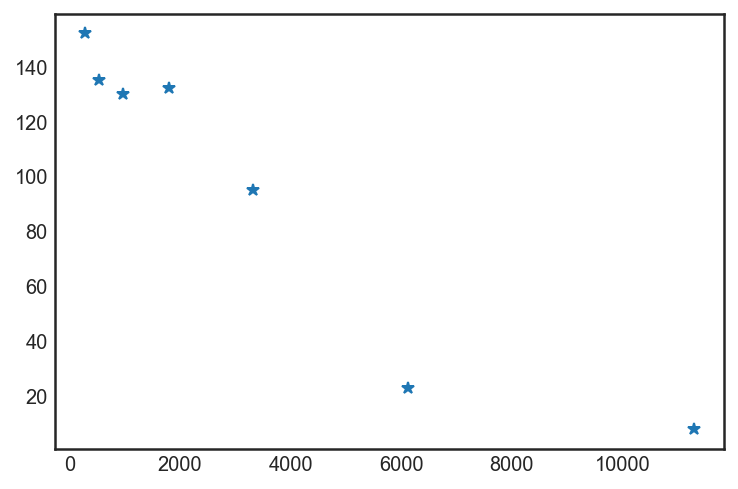

In [43]:
plt.plot(Ener,no_events,'*');

In [44]:
#events_wo_back= np.loadtxt('number_of_events_bck.txt',usecols=1,unpack=True)

Text(0,0.5,u'No_Events')

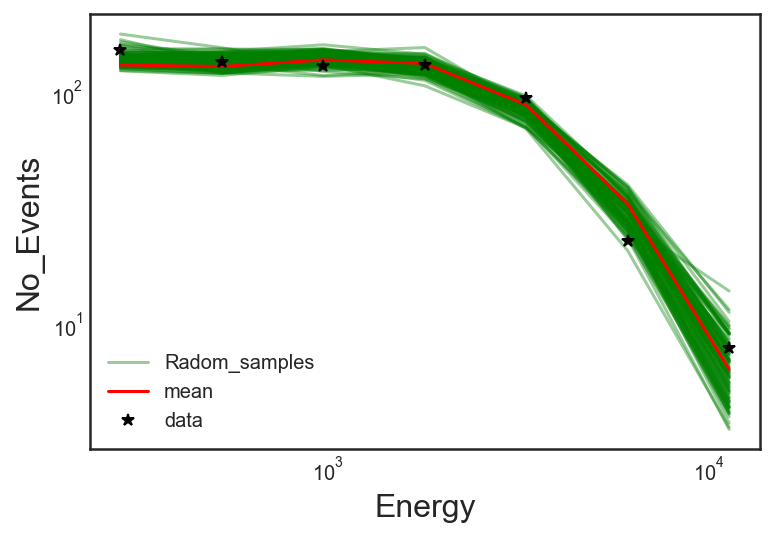

In [45]:
fig1 = plt.figure()

for c1,c2,c3,c4,c5 in sampler.flatchain[np.random.randint(len(sampler.flatchain), size=100)]:
    val_1 = no_events_pulsar_complete([c1,c2,c3,c4,c5],e_min,e_max)
    fig_1,=plt.loglog(Ener,val_1,'g',alpha=0.4);

val1_mean = no_events_pulsar_complete([np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2]),
                                   np.mean(sampler.flatchain[:,3]),np.mean(sampler.flatchain[:,4])],e_min,e_max)

fig_2,=plt.loglog(Ener,val1_mean,'r');
#fig_2,=plt.plot(Ener,no_events_model_pulsar([np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2])],e_min,e_max)+ background);
#plt.plot(Ener,no_events,'*b');
fig_3,=plt.loglog(Ener,no_events,'*k');
plt.legend([fig_1,fig_2,fig_3],['Radom_samples','mean','data'],loc='best')
plt.xlabel('Energy',fontsize=16)
plt.ylabel('No_Events',fontsize=16)
#plt.plot(Ener,no_events_model_pulsar([-0.23,3.14,-1.18],e_min,e_max),'b');

fig1.savefig('data/results_25bins.pdf')

In [46]:
print no_events_model_pulsar([-.6,3.9,-2.29],e_min,e_max)

[1.48742644e+11 1.31996127e+12 9.09508342e+12 4.65283321e+13
 1.63541930e+14 3.94692307e+14 6.44281129e+14]


In [47]:
np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2])

(1.4300044348746428, 3.413601065978759, -7.151937583280565)

In [48]:
print e_min

[ 200.          369.37524414  682.19030762 1259.92102051 2326.91821289
 4297.52929688 7937.00537109]


In [49]:
print e_max

[  369.37524414   682.19030762  1259.92102051  2326.91821289
  4297.52929688  7937.00537109 14658.66601562]


In [50]:
print background

[110.24082894  78.7613955   47.62285019  23.67265219  10.35734039
   4.28320615   1.93644739]


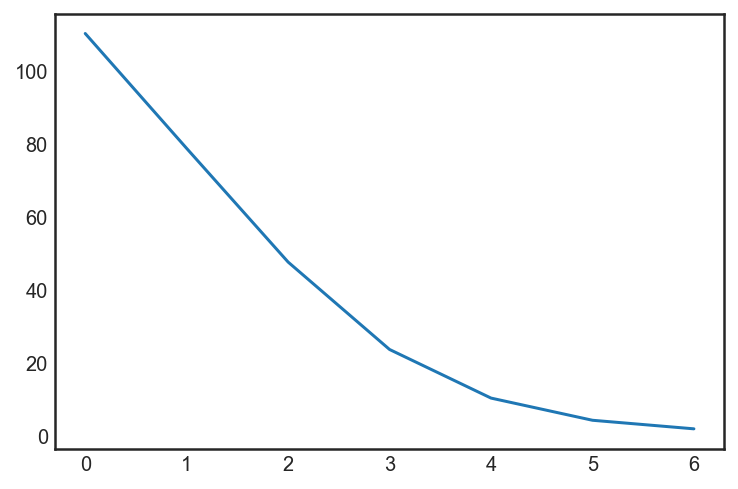

In [51]:
plt.plot(background)

In [52]:
def N_Pulsars_Ecut(chains):

    d = 5.2 * (1000.*100.) * 3.0857e16 #cm
    eta = 0.08
    E_dot = 2.0e34
    
    S = np.zeros(len(chains))
    
    for i in range(len(chains)):
        
        C_s = [chains[i,0],chains[i,1],chains[i,2]]
        integrand = lambda x: x * E2dNdE_pulsar(C_s,x)
        
        S[i] = integrate.quad(integrand,0.01,np.inf)[0]
    
    L = 4.0 * np.pi * S * d**2
    N_events = (L*1.602e-6) /(E_dot * eta)
    
    return N_events

In [53]:
chain_Np = N_Pulsars_Ecut(sampler.flatchain)

In [54]:
new_chain = np.append(sampler.flatchain,chain_Np[:,None],axis=1)

In [55]:
labels2 = [r'$\Gamma$',r'$log10(E_{cut})$','log10(N0)',r'$log10(N_N)$',r'$\alpha$',r'$N_{Pulsars}$']

In [59]:
ranges = ((0.,2.5), (2.6,4.), (-14.,0.),(-15.,0.),(0,5),(0,250))

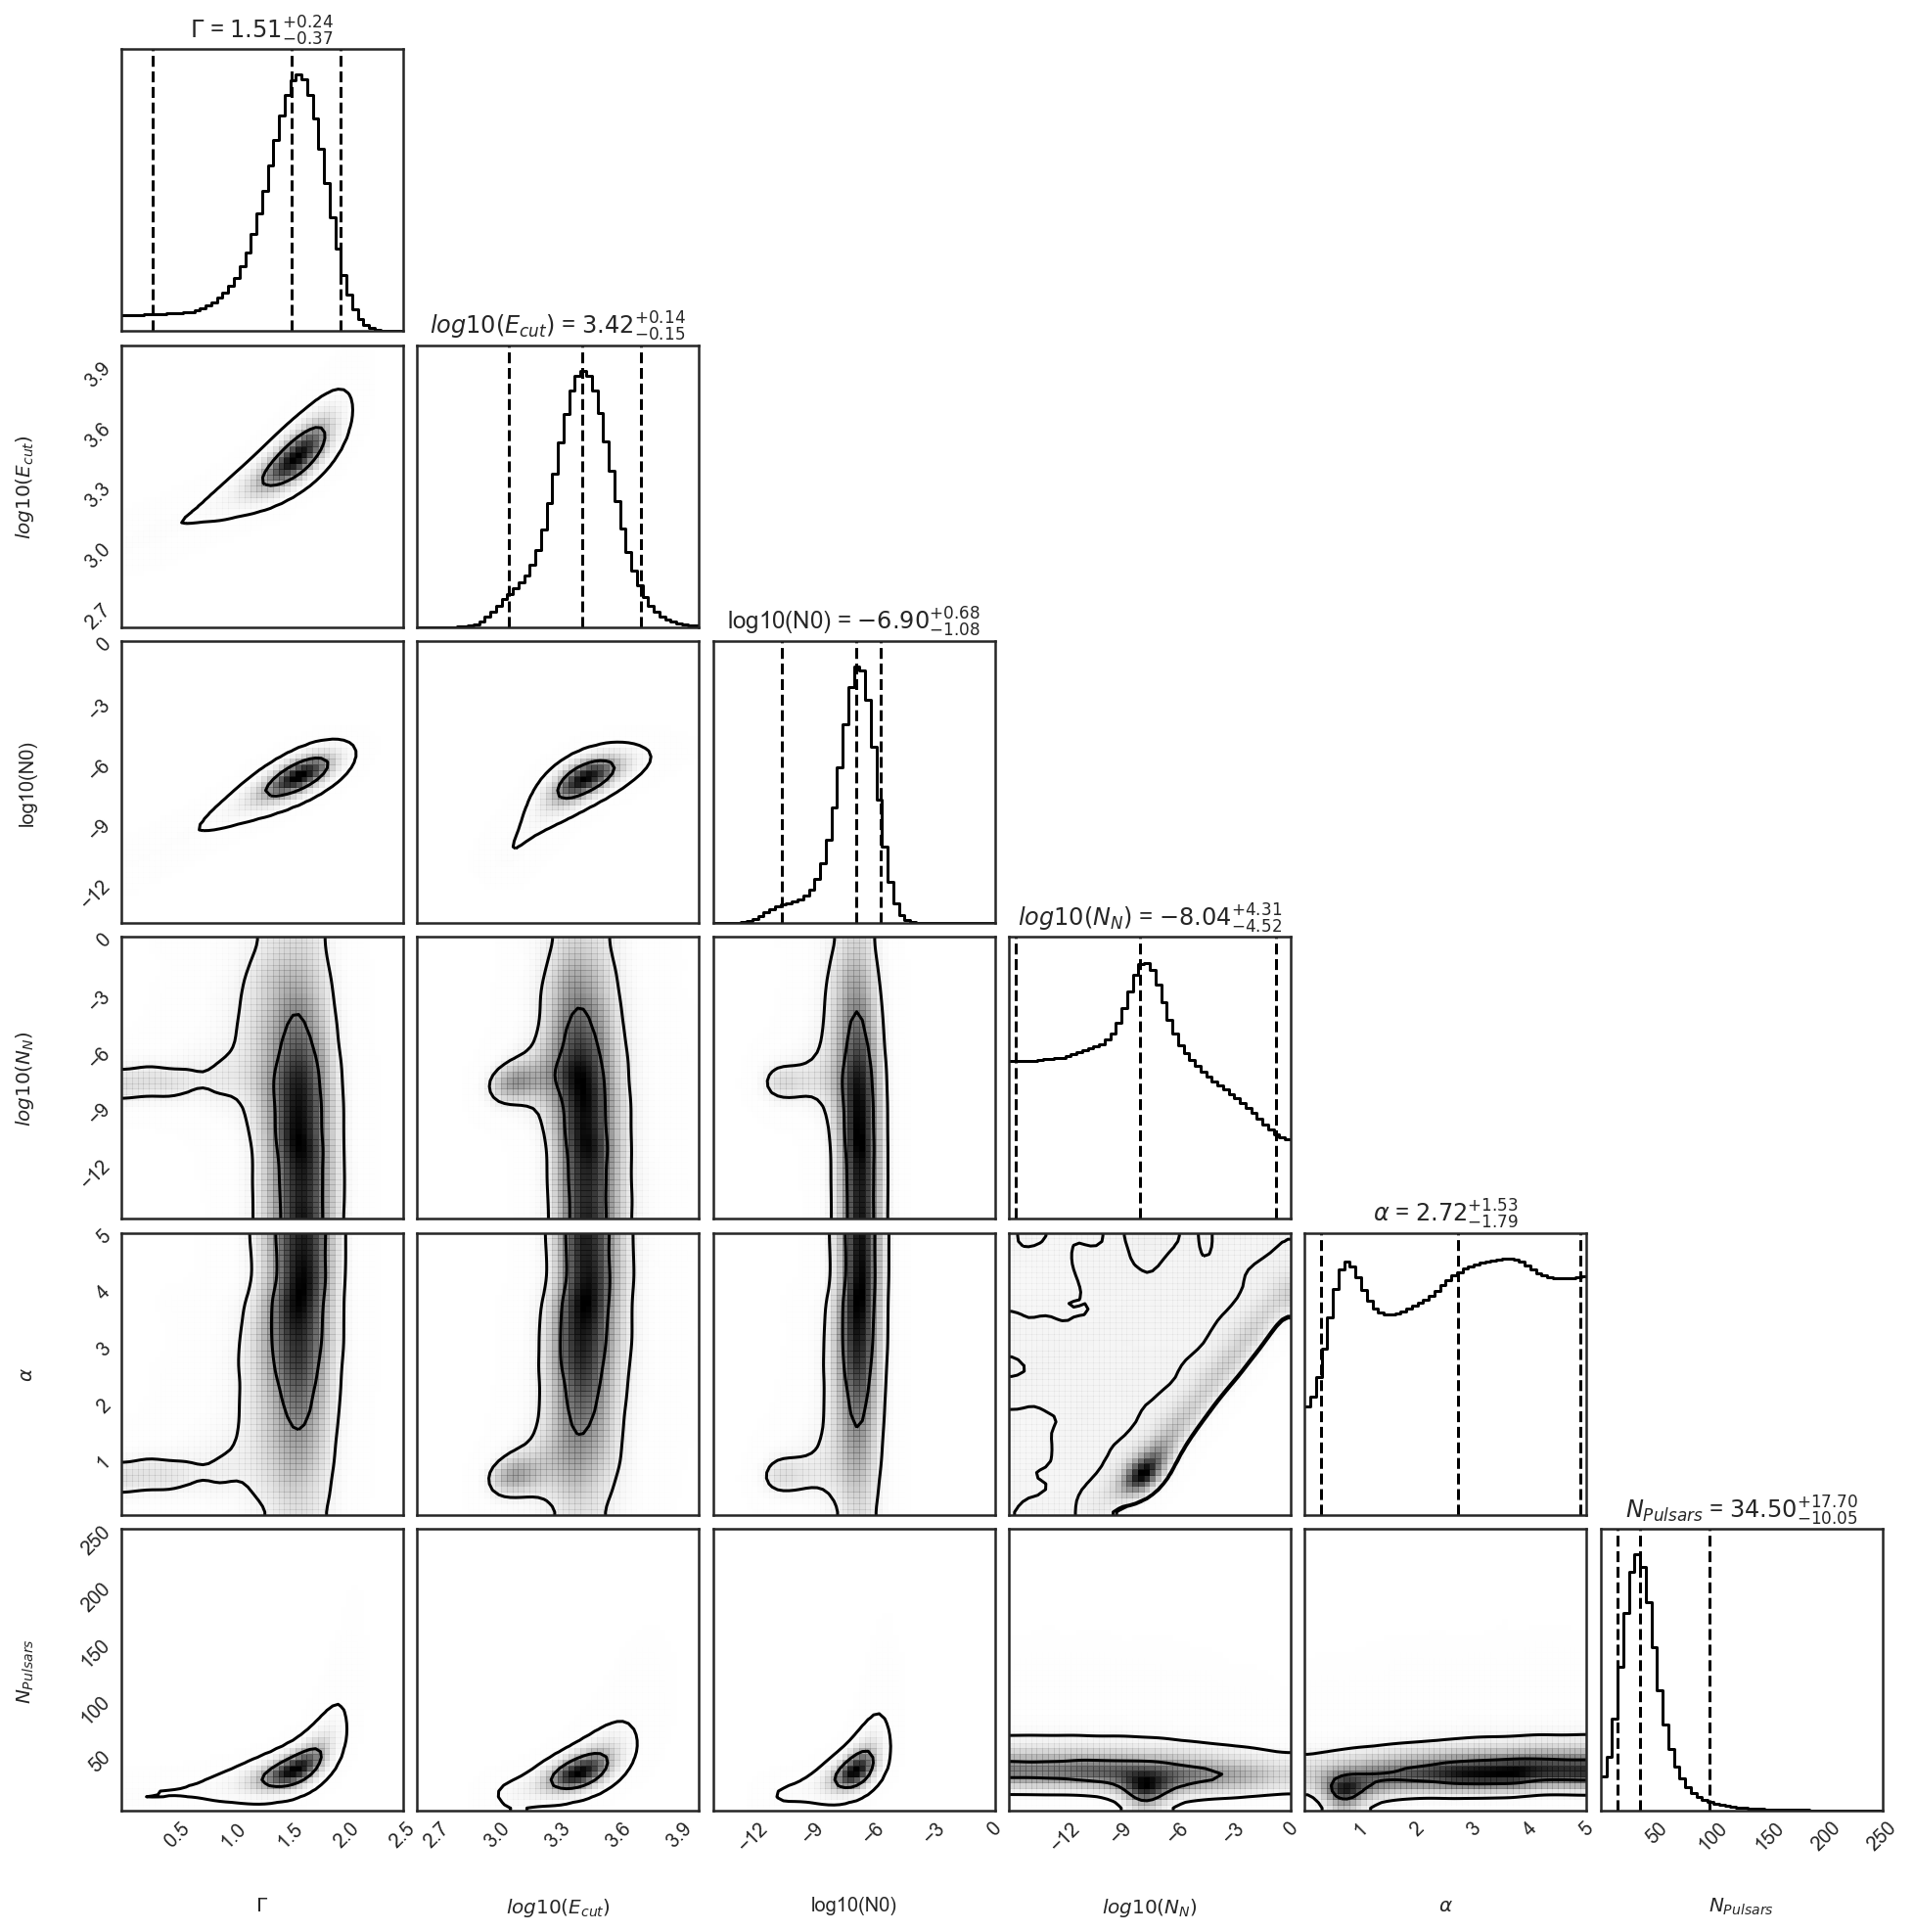

In [60]:
fig_count= corner.corner(new_chain,bins=50,range=ranges,labels=labels2,plot_datapoints=False,smooth=2., 
                    smooth1d=2,levels=(1.-np.exp(-0.5),1.-np.exp(-2.)),quantiles=[.025,0.5,0.975],show_titles=True);

fig_count.savefig('data/ecut_0709_newsource_flat.pdf')

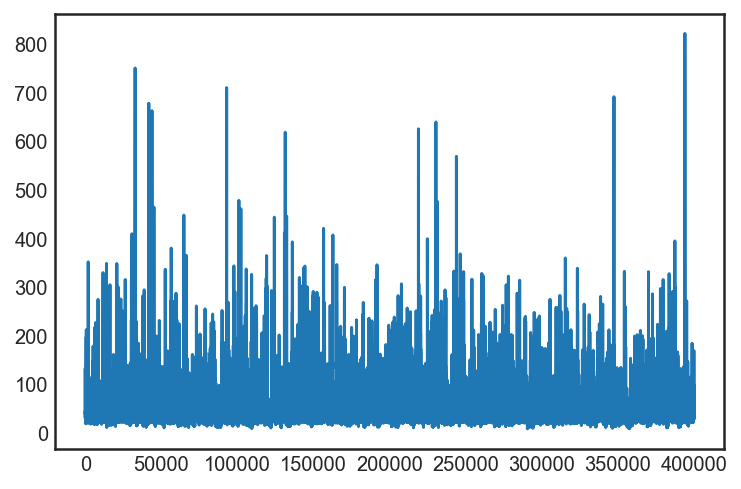

In [58]:
plt.plot(chain_Np);